<a href="https://colab.research.google.com/github/benedictmartus/Systainable-Systems-Engineering/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Starting Traffic Simulation Setup ---
Selected Scenario: 1
Parameters: N_cells=15, L_cell=90.0m, T=5.0s, q_max=1.11veh/s
ALINEA: Setpoint=0.062 veh/m, KR=0.0194 veh/s
Generating demand profiles...
Initializing state variables...
--- Starting Simulation Loop (Steps: 1080) ---
--- Simulation Finished (Took 0.35 seconds) ---
Generating plots...


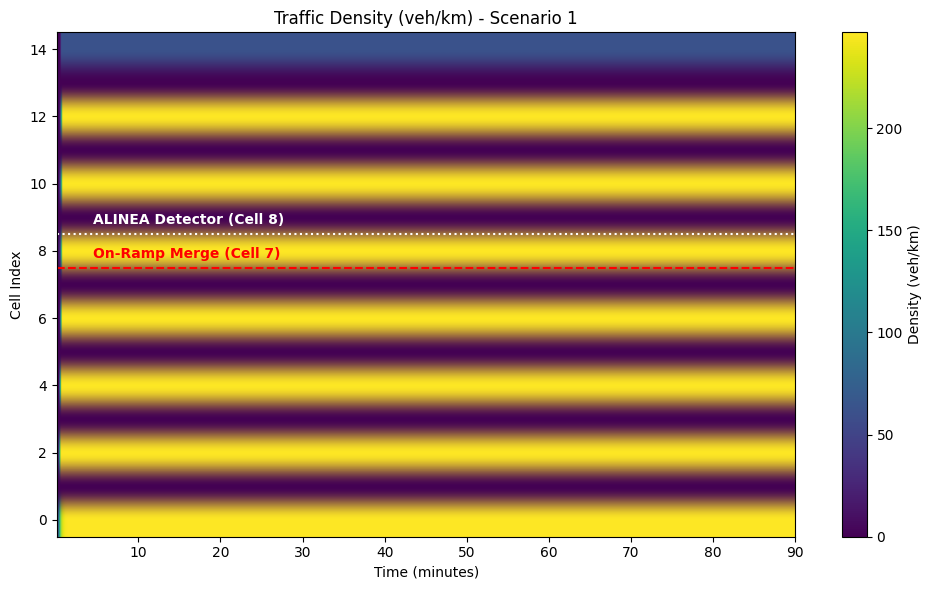

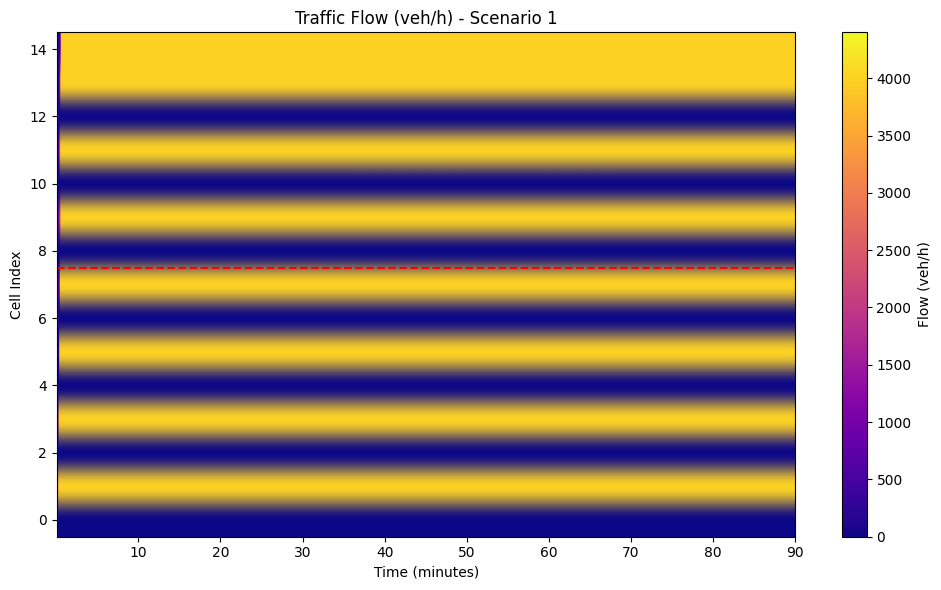

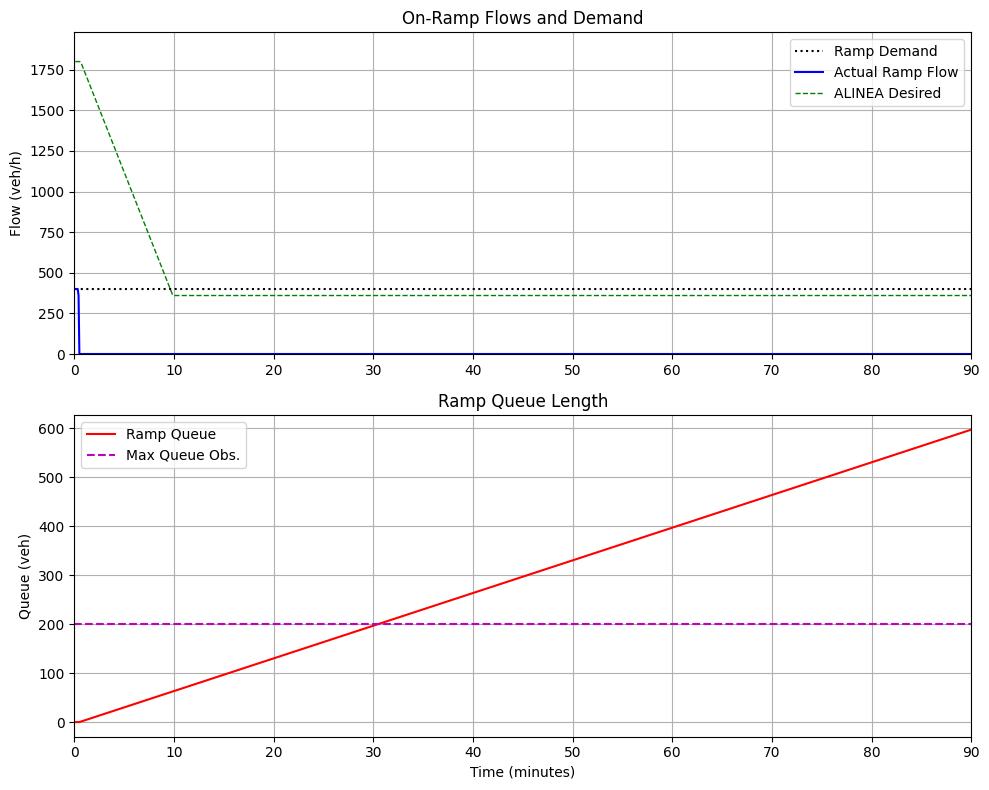

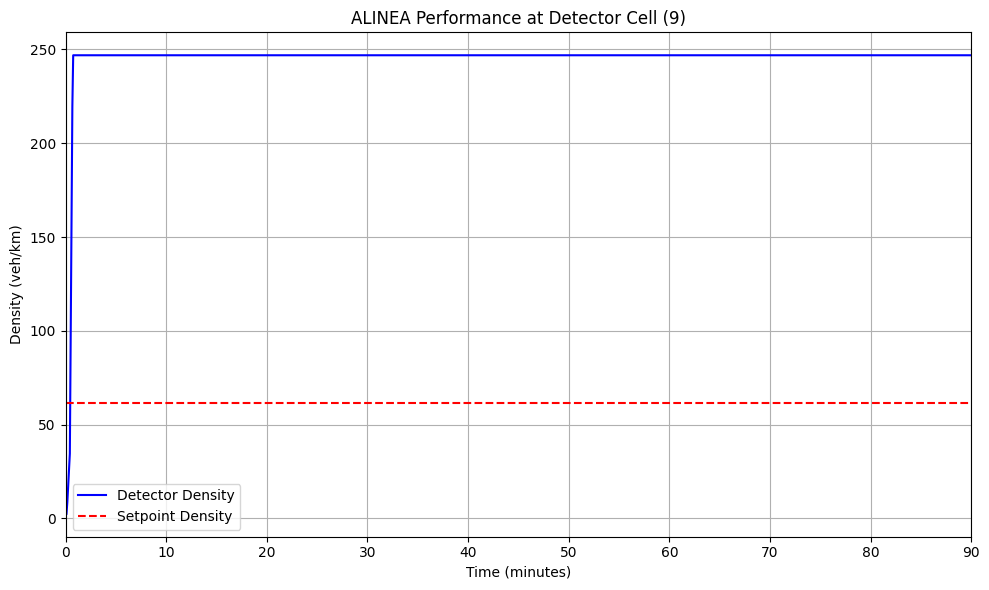

--- Plotting Finished ---


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

# =========================================================================
# PYTHON SCRIPT: ACTM Traffic Simulation with ALINEA Controller
# =========================================================================
#
# Description:
# This script simulates traffic flow on a freeway section using the
# Asymmetric Cell Transmission Model (ACTM). It includes one on-ramp
# controlled by the ALINEA ramp metering algorithm. It allows running
# three different traffic demand scenarios.
#
# How to Use:
# 1. Save this code as a single .py file (e.g., 'traffic_sim.py').
# 2. Change the 'scenario_to_run' variable below to 1, 2, or 3.
# 3. Run the script from your Python environment.
# 4. Analyze the generated plots.
#
# =========================================================================

# --- 1. SCRIPT SETUP ---
print('--- Starting Traffic Simulation Setup ---')

# --- 2. SCENARIO SELECTION ---
# Choose which scenario to run by setting this variable:
# 1: Low Demand      (Free flow, ALINEA likely inactive)
# 2: Peak Demand     (Congestion onset, tests ALINEA)
# 3: High Demand     (Forced congestion, tests limits)
scenario_to_run = 1
print(f'Selected Scenario: {scenario_to_run}')

# --- 3. MODEL PARAMETERS ---
# --- Simulation Parameters ---
T = 5                  # Time step (seconds). IMPORTANT: L = vf * T
sim_duration_min = 90  # Total simulation duration (minutes)
sim_time_steps = round(sim_duration_min * 60 / T) # Number of time steps

# --- Highway Parameters ---
N_cells = 15           # Number of mainline cells (>= class example)
vf = 18                # Free-flow speed (m/s) -> ~65 km/h
L_cell = vf * T        # Cell length (m) -> Ensures CFL condition (90m)
w = 6                  # Congestion wave speed (m/s) -> ~22 km/h
q_max_vphpl = 2000     # Capacity (veh/h per lane)
N_lanes = 2            # Number of lanes
q_max = (q_max_vphpl * N_lanes) / 3600 # Total capacity (veh/s)
k_crit = q_max / vf    # Critical density (veh/m)
k_jam = k_crit + q_max / w # Jam density (veh/m)

# --- Ramp & Control Parameters ---
ramp_merge_cell = 8    # Cell *receiving* the on-ramp flow (1-indexed)
detector_cell = ramp_merge_cell + 1 # Cell *after* merge for ALINEA measurement (1-indexed)
q_ramp_max = 1800 / 3600 # Max physical ramp flow (veh/s)
r_min = 360 / 3600     # Min metering rate (veh/s)
r_max = q_ramp_max     # Max metering rate (veh/s)
rho_setpoint = k_crit  # ALINEA setpoint = critical density (veh/m)
KR_base = 70           # ALINEA gain (veh/h). *** NEEDS TUNING! ***
KR = KR_base / 3600    # Convert KR to (veh/s) for calculation
Q_max_veh = 200        # Max ramp queue (veh) - for observation/potential override

print(f'Parameters: N_cells={N_cells}, L_cell={L_cell:.1f}m, T={T:.1f}s, q_max={q_max:.2f}veh/s')
print(f'ALINEA: Setpoint={rho_setpoint:.3f} veh/m, KR={KR:.4f} veh/s')

# --- 4. DEMAND PROFILE GENERATION ---
print('Generating demand profiles...')
mainline_demand_vph = np.zeros(sim_time_steps)
ramp_demand_vph = np.zeros(sim_time_steps)
time_vec_min = np.arange(1, sim_time_steps + 1) * T / 60 # Time vector in minutes

if scenario_to_run == 1: # Low Demand
    mainline_demand_vph[:] = 1500 * N_lanes
    ramp_demand_vph[:] = 400
elif scenario_to_run == 2: # Peak Demand
    peak_start = 15; peak_mid = 40; peak_end = 65 # Minutes
    base_main = 1000; peak_main = 2000
    base_ramp = 300; peak_ramp = 900
    for k in range(sim_time_steps):
        t_min = time_vec_min[k]
        if t_min < peak_start:
            mainline_demand_vph[k] = base_main * N_lanes
            ramp_demand_vph[k] = base_ramp
        elif t_min < peak_mid:
            frac = (t_min - peak_start) / (peak_mid - peak_start)
            mainline_demand_vph[k] = (base_main + frac * (peak_main - base_main)) * N_lanes
            ramp_demand_vph[k] = (base_ramp + frac * (peak_ramp - base_ramp))
        elif t_min < peak_end:
            frac = (t_min - peak_mid) / (peak_end - peak_mid)
            mainline_demand_vph[k] = (peak_main - frac * (peak_main - base_main)) * N_lanes
            ramp_demand_vph[k] = (peak_ramp - frac * (peak_ramp - base_ramp))
        else:
            mainline_demand_vph[k] = base_main * N_lanes
            ramp_demand_vph[k] = base_ramp
elif scenario_to_run == 3: # High Demand
    mainline_demand_vph[:] = 2400 * N_lanes
    ramp_demand_vph[:] = 1200
    # Optional: Add an incident by reducing q_max temporarily
    # incident_cell = 11
    # incident_start_step = round(20 * 60 / T)
    # incident_end_step = round(40 * 60 / T)
else:
    raise ValueError('Invalid scenario selection. Choose 1, 2, or 3.')

# Convert demand to veh/s
mainline_demand = mainline_demand_vph / 3600
ramp_demand = ramp_demand_vph / 3600

# --- 5. INITIALIZATION ---
print('Initializing state variables...')
# Densities (veh/m) - rho[cell_idx, time_step_idx]
rho = np.ones((N_cells, sim_time_steps)) * 0.01 * k_jam
# Flows (veh/s) - y[flow_idx, time_step_idx]
# y[0] is flow into cell 0 from mainline demand
# y[i+1] is flow into cell i+1 from cell i (0-indexed cells)
# So y has N_cells+1 rows: y[0] to y[N_cells]
y = np.zeros((N_cells + 1, sim_time_steps))
Q_ramp = np.zeros(sim_time_steps)      # Ramp queue (veh)
r_ramp_actual = np.zeros(sim_time_steps) # Actual ramp flow (veh/s)
r_ramp_alinea = np.zeros(sim_time_steps) # ALINEA desired rate (veh/s)

# Initial conditions for ALINEA
r_ramp_alinea[0] = r_max

# --- 6. SIMULATION LOOP ---
print(f'--- Starting Simulation Loop (Steps: {sim_time_steps}) ---')
start_time = time.time()

# Adjust detector_cell and ramp_merge_cell to be 0-indexed for array access
detector_cell_idx = detector_cell - 1
ramp_merge_cell_idx = ramp_merge_cell - 1

for k in range(sim_time_steps - 1):
    # --- A. Calculate Demand (S) and Supply (R) for each cell ---
    S = np.minimum(vf * rho[:, k], q_max) # S[i] is sending flow from cell i (0 to N_cells-1)

    # R is receiving capacity. R[i] is receiving capacity of cell i.
    # We need R for cells 0 to N_cells-1, and an "effective R" for the sink after cell N_cells-1
    # So, R needs N_cells elements for cells 0 to N_cells-1 based on density,
    # and then effectively q_max for the outflow from the last cell.
    R_current = np.minimum(w * (k_jam - rho[:, k]), q_max) # R_current[i] is for cell i

    # --- B. ALINEA Controller Calculation ---
    rho_measured = rho[detector_cell_idx, k]
    r_calc = r_ramp_alinea[k] + KR * (rho_setpoint - rho_measured)
    r_desired = max(r_min, min(r_max, r_calc)) # Apply min/max constraints
    r_ramp_alinea[k + 1] = r_desired # Store desired rate for next step

    # --- C. Determine Potential Ramp Flow (y_r_potential) ---
    demand_plus_queue = (ramp_demand[k] * T + Q_ramp[k]) / T
    y_r_potential = min(r_desired, demand_plus_queue)
    y_r_potential = min(y_r_potential, q_ramp_max)

    # --- D. Calculate Flows (y) ---
    # y[i_target, k] represents flow INTO cell i_target at time k
    # y[0, k] is mainline flow into cell 0
    # y[cell_idx + 1, k] is flow from cell cell_idx to cell cell_idx + 1

    # Mainline Inflow (flow into cell 0)
    y[0, k] = min(mainline_demand[k], R_current[0])

    # Temporary array to hold flows between cells (from cell i to cell i+1)
    # y_inter_cell[i] is flow from cell i to cell i+1
    y_inter_cell_flows = np.zeros(N_cells)

    # Calculate flows for standard cells (not at merge)
    for i in range(N_cells):
        if i == ramp_merge_cell_idx - 1: # Cell before the merge cell (its outflow needs ACTM)
            pass # Handled below in ACTM section
        elif i == ramp_merge_cell_idx: # The merge cell itself (its outflow is standard)
            # This is flow from merge_cell to merge_cell+1
            y_inter_cell_flows[i] = min(S[i], R_current[i+1] if i+1 < N_cells else q_max)
        elif i < ramp_merge_cell_idx - 1: # Cells strictly before merge influence
            y_inter_cell_flows[i] = min(S[i], R_current[i+1])
        elif i > ramp_merge_cell_idx: # Cells strictly after merge influence
            # For the last cell's outflow (i = N_cells - 1), R_current[i+1] would be out of bounds.
            # R_current[i+1] should be q_max or a large number for the sink.
            y_inter_cell_flows[i] = min(S[i], R_current[i+1] if i+1 < N_cells else q_max)

    # ACTM Merge Logic: Flow from cell `ramp_merge_cell_idx - 1` to `ramp_merge_cell_idx`
    # and ramp flow into `ramp_merge_cell_idx`
    i_m_prev = ramp_merge_cell_idx - 1 # Index of cell *before* the merge cell
    i_m = ramp_merge_cell_idx         # Index of the merge cell

    S_main = S[i_m_prev]          # Sending flow from cell before merge
    R_merge = R_current[i_m]      # Receiving flow for the merge cell

    # Calculate mainline flow assuming no ramp interference initially
    y_main_potential = min(S_main, R_merge)

    # Then, calculate how much supply is left for the ramp in the merge cell
    R_for_ramp = max(0, R_merge - y_main_potential)

    # Ramp flow takes what it can from remaining supply, up to its potential
    y_ramp = min(y_r_potential, R_for_ramp)

    # Recalculate mainline flow considering ramp has taken some capacity
    # This is the actual flow from i_m_prev to i_m
    y_main = min(S_main, R_merge - y_ramp)

    # Store the actual inter-cell flow for the section before merge
    y_inter_cell_flows[i_m_prev] = y_main
    r_ramp_actual[k] = y_ramp       # Actual ramp flow

    # Now, populate the main `y` array which represents flow *into* each cell
    # y[0, k] is already set (mainline_demand -> cell 0)
    for i in range(N_cells): # Loop through each cell index as the *target* cell
        if i == 0:
            # Flow into cell 0 is y[0,k], already calculated as mainline_demand.
            # This loop iteration is primarily for y[i+1,k]
            pass
        elif i == i_m: # If the current target cell is the merge cell
            # Flow into merge cell `i_m` comes from `i_m-1` (mainline) and the ramp
            y[i_m + 1, k] = y_inter_cell_flows[i_m_prev] + r_ramp_actual[k]
        else:
            # Standard flow into cell `i` from cell `i-1`
            y[i + 1, k] = y_inter_cell_flows[i-1]

    # Flow out of the last cell (cell N_cells-1) to the sink
    # This is y[N_cells, k]
    y[N_cells, k] = y_inter_cell_flows[N_cells - 1]


    # --- E. Update Ramp Queue ---
    Q_ramp[k + 1] = max(0, Q_ramp[k] + T * (ramp_demand[k] - r_ramp_actual[k]))
    # Optional: Implement queue override for ramp metering (if Q_ramp > Q_max_veh)
    # For simplicity, not implemented here as per Matlab code.

    # --- F. Update Densities ---
    for i in range(N_cells):
        rho[i, k + 1] = rho[i, k] + (T / L_cell) * (y[i, k] - y[i + 1, k])
        # Enforce physical bounds [0, k_jam]
        rho[i, k + 1] = max(0, min(k_jam, rho[i, k + 1]))

    # Optional: Incident implementation (commented out as in Matlab)
    # if k >= incident_start_step and k < incident_end_step:
    #     q_max_current = q_max_incident
    # else:
    #     q_max_current = q_max
    # S = np.minimum(vf * rho[:, k], q_max_current) # Recalculate S if incident

end_time = time.time()
print(f'--- Simulation Finished (Took {end_time - start_time:.2f} seconds) ---')

# --- 7. PLOTTING & ANALYSIS ---
print('Generating plots...')

# Convert units for better plot readability
rho_plot = rho * 1000 # veh/km
k_jam_plot = k_jam * 1000
rho_setpoint_plot = rho_setpoint * 1000
y_plot = y * 3600 # veh/h
mainline_demand_plot = mainline_demand * 3600
ramp_demand_plot = ramp_demand * 3600
r_ramp_actual_plot = r_ramp_actual * 3600
r_ramp_alinea_plot = r_ramp_alinea * 3600

# Figure 1: Density Heatmap (Fundamental Diagram in action)
plt.figure('Scenario ' + str(scenario_to_run) + ' - Density', figsize=(10, 6))
# Only plot densities for cells 0 to N_cells-1
plt.imshow(rho_plot, aspect='auto', origin='lower',
           extent=[time_vec_min.min(), time_vec_min.max(), -0.5, N_cells - 0.5], # Adjust y-axis to match 0 to N_cells-1
           vmin=0, vmax=k_jam_plot, cmap='viridis')
plt.colorbar(label='Density (veh/km)')
plt.xlabel('Time (minutes)')
plt.ylabel('Cell Index')
plt.title(f'Traffic Density (veh/km) - Scenario {scenario_to_run}')
# Adjust horizontal lines for 0-indexed cells
plt.axhline(y=ramp_merge_cell_idx + 0.5, color='r', linestyle='--', linewidth=1.5, label='On-Ramp Merge')
plt.text(time_vec_min.max()*0.05, ramp_merge_cell_idx + 0.8, f'On-Ramp Merge (Cell {ramp_merge_cell_idx})', color='r', fontweight='bold')
plt.axhline(y=detector_cell_idx + 0.5, color='w', linestyle=':', linewidth=1.5, label='ALINEA Detector')
plt.text(time_vec_min.max()*0.05, detector_cell_idx + 0.8, f'ALINEA Detector (Cell {detector_cell_idx})', color='w', fontweight='bold')
plt.grid(False) # Turn off grid for imshow
plt.tight_layout()

# Figure 2: Flow Heatmap
plt.figure('Scenario ' + str(scenario_to_run) + ' - Flow', figsize=(10, 6))
# Plot flows *into* each cell, from y[1] to y[N_cells] which correspond to cell 0 to cell N_cells-1
plt.imshow(y_plot[1:N_cells+1, :], aspect='auto', origin='lower',
           extent=[time_vec_min.min(), time_vec_min.max(), -0.5, N_cells - 0.5], # Adjust y-axis to match 0 to N_cells-1
           vmin=0, vmax=q_max * 3600 * 1.1, cmap='plasma')
plt.colorbar(label='Flow (veh/h)')
plt.xlabel('Time (minutes)')
plt.ylabel('Cell Index')
plt.title(f'Traffic Flow (veh/h) - Scenario {scenario_to_run}')
# Adjust horizontal line for 0-indexed cell
plt.axhline(y=ramp_merge_cell_idx + 0.5, color='r', linestyle='--', linewidth=1.5, label='On-Ramp Merge')
plt.grid(False) # Turn off grid for imshow
plt.tight_layout()

# Figure 3: Ramp Dynamics (Demand, Flow, Queue)
plt.figure('Scenario ' + str(scenario_to_run) + ' - Ramp Dynamics', figsize=(10, 8))
plt.subplot(2, 1, 1) # Top plot: Flows
plt.plot(time_vec_min, ramp_demand_plot, 'k:', linewidth=1.5, label='Ramp Demand')
plt.plot(time_vec_min, r_ramp_actual_plot, 'b-', linewidth=1.5, label='Actual Ramp Flow')
plt.plot(time_vec_min, r_ramp_alinea_plot, 'g--', linewidth=1, label='ALINEA Desired')
plt.ylabel('Flow (veh/h)')
plt.title('On-Ramp Flows and Demand')
plt.legend(loc='best')
plt.grid(True)
plt.xlim(0, sim_duration_min)
plt.ylim(0, r_max * 3600 * 1.1)

plt.subplot(2, 1, 2) # Bottom plot: Queue
plt.plot(time_vec_min, Q_ramp, 'r-', linewidth=1.5, label='Ramp Queue')
plt.plot([0, sim_duration_min], [Q_max_veh, Q_max_veh], 'm--', label='Max Queue Obs.')
plt.ylabel('Queue (veh)')
plt.xlabel('Time (minutes)')
plt.title('Ramp Queue Length')
plt.legend(loc='best')
plt.grid(True)
plt.xlim(0, sim_duration_min)
plt.tight_layout()

# Figure 4: ALINEA Performance
plt.figure('Scenario ' + str(scenario_to_run) + ' - ALINEA Performance', figsize=(10, 6))
plt.plot(time_vec_min, rho_plot[detector_cell_idx, :], 'b-', linewidth=1.5, label='Detector Density')
plt.plot([0, sim_duration_min], [rho_setpoint_plot, rho_setpoint_plot], 'r--', linewidth=1.5, label='Setpoint Density')
plt.xlabel('Time (minutes)')
plt.ylabel('Density (veh/km)')
plt.title(f'ALINEA Performance at Detector Cell ({detector_cell})')
plt.legend(loc='best')
plt.grid(True)
plt.xlim(0, sim_duration_min)
plt.tight_layout()

plt.show() # Display all figures
print('--- Plotting Finished ---')

# =========================================================================
# --- END OF SCRIPT ---
# =========================================================================